In [1]:
import sys
print(sys.path)
sys.path.append('/home/zinovyev/anaconda3/lib/python3.7/site-packages')
sys.path.append('/home/zinovyev/anaconda3/lib/python3.7/site-packages/skdim/')
print(sys.path)

['/mnt/c/Datas/SingleCellTranscriptomics/RNAVelocity', '/usr/lib/python37.zip', '/usr/lib/python3.7', '/usr/lib/python3.7/lib-dynload', '', '/home/zinovyev/.local/lib/python3.7/site-packages', '/usr/local/lib/python3.7/dist-packages', '/usr/lib/python3/dist-packages', '/home/zinovyev/.local/lib/python3.7/site-packages/IPython/extensions', '/home/zinovyev/.ipython']
['/mnt/c/Datas/SingleCellTranscriptomics/RNAVelocity', '/usr/lib/python37.zip', '/usr/lib/python3.7', '/usr/lib/python3.7/lib-dynload', '', '/home/zinovyev/.local/lib/python3.7/site-packages', '/usr/local/lib/python3.7/dist-packages', '/usr/lib/python3/dist-packages', '/home/zinovyev/.local/lib/python3.7/site-packages/IPython/extensions', '/home/zinovyev/.ipython', '/home/zinovyev/anaconda3/lib/python3.7/site-packages', '/home/zinovyev/anaconda3/lib/python3.7/site-packages/skdim/']


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scvelo as sv
import anndata
import scanpy as sc
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

def ismember(A, B):
    dct = {}
    for s,i in enumerate(B):
        dct[i] = s
    return [ dct[a] for a in A ]

def load_signature_file(file):
    sigs = {}
    with open(file,'r',encoding="utf8",errors='ignore') as fin:
        line = fin.readline().strip('\n').strip(' ')
        while line:
            parts = line.split('\t')
            lst = parts[2:]
            lst = [s.split('[')[0] for s in lst if not s=='']
            sigs[parts[0]] = lst
            line = fin.readline().strip('\n').strip(' ')
    return sigs

def load_weighted_signature_file(file):
    sigs = {}
    with open(file,'r',encoding="utf8",errors='ignore') as fin:
        line = fin.readline().strip('\n').strip(' ')
        while line:
            parts = line.split('\t')
            lst = parts[2:]
            lst1 = [s.split('[')[0] for s in lst if not s=='']
            weights = [float(s.split('[')[1].split(']')[0]) for s in lst if not s=='']
            #print(lst1,weights)
            sigs[parts[0]] = (lst1,weights)
            #sigs[parts[0]+'_W'] = weights
            line = fin.readline().strip('\n').strip(' ')
    return sigs

def calc_scores(anndata,signature_dict):
    matrix = anndata.to_df().to_numpy()
    scores_dic = {}
    for key in signature_dict:
        names = np.array(signature_dict[key])
        inds = np.where(np.isin(anndata.var_names,names))[0]
        matrix_sel = matrix[:,inds]
        scores = np.mean(matrix_sel,axis=1)
        scores_dic[key] = scores
    return scores_dic

def calc_weighted_scores(anndata,signature_dict):
    matrix = anndata.to_df().to_numpy()
    scores_dic = {}
    for key in signature_dict:
        names_weights = signature_dict[key]
        names = names_weights[0]
        weights = np.array(names_weights[1])
        inds = np.where(np.isin(anndata.var_names,names))[0]
        sel_names = anndata.var_names[inds]
        ind_in_names = ismember(sel_names,names)
        names1 = np.array(names)[ind_in_names]
        weights1 = np.array(weights)[ind_in_names]
        inds = ismember(names1,anndata.var_names)
        matrix_sel = matrix[:,inds]
        gene_means = np.mean(matrix_sel,axis=0)
        meanmat = np.outer(np.ones(matrix_sel.shape[0]),gene_means)
        matrix_sel = matrix_sel-meanmat
        scores = np.matmul(matrix_sel,weights1)
        scores_dic[key] = scores
    return scores_dic


def calc_histone_score(adata2k):
    histone_names1 = np.argwhere(adata2k.var_names.str.startswith('H1'))
    histone_names2 = np.argwhere(adata2k.var_names.str.startswith('H2'))
    histone_names3 = np.argwhere(adata2k.var_names.str.startswith('H3'))
    histone_names4 = np.argwhere(adata2k.var_names.str.startswith('H4'))
    histone_names5 = np.argwhere(adata2k.var_names.str.startswith('HIST'))
    histone_names = np.union1d(np.union1d(histone_names1,histone_names2),np.union1d(histone_names3,histone_names4))
    histone_names = np.union1d(histone_names,histone_names5)
    histone_names = adata2k.var_names[histone_names]
    print('Found histone genes:',*histone_names)
    inds_histones = np.where(np.isin(adata2k.var_names,histone_names))[0]
    matrix = adata2k.to_df().to_numpy()
    matrix_sel = matrix[:,inds_histones]
    scores = np.mean(matrix_sel,axis=1)
    return scores

def smooth_adata_by_pooling(adata,X_embed,n_neighbours=10):
    adata_pooled = adata.copy()
    nbrs = NearestNeighbors(n_neighbors=n_neighbours).fit(X_embed)
    distances, indices = nbrs.kneighbors(X_embed)    
    adata_pooled.X = smooth_matrix_by_pooling(get_nd_array(adata.X),indices)
    if 'matrix' in adata.layers:
        adata_pooled.layers['matrix'] = smooth_matrix_by_pooling(get_nd_array(adata.layers['matrix']),indices)
    if 'spliced' in adata.layers:
        adata_pooled.layers['spliced'] = smooth_matrix_by_pooling(get_nd_array(adata.layers['spliced']),indices)
    if 'unspliced' in adata.layers:
        adata_pooled.layers['unspliced'] = smooth_matrix_by_pooling(get_nd_array(adata.layers['unspliced']),indices)
    return adata_pooled

def smooth_matrix_by_pooling(matrix,indices):
    matrix_pooled = matrix.copy()
    for i in range(len(indices)):
        matrix_pooled[i,:] = np.mean(matrix[indices[i],:],axis=0)
    return matrix_pooled

def get_nd_array(arr):
    x = None
    if str(type(arr)):
        x = arr
    else:
        x = arr.toarray()
    return x

    
def preprocessing_without_pooling(adata):
    if not Already_Log_Transformed:
        sc.pp.log1p(adata)
    if Normalize_Totals:
        sc.pp.normalize_total(adata, target_sum=10000)
    if top_variable_genes>0:
        #sc.pp.highly_variable_genes(adata,n_top_genes=top_variable_genes,n_bins=20)
        #ind_genes = np.where(adata.var['highly_variable'])[0]
        vars = np.var(adata.X,axis=0)
        inds = np.flip(np.argsort(vars))
        ind_genes = inds[0:top_variable_genes]
        if 0 in vars[ind_genes]:
            ind_first_zero = np.argwhere(vars[ind_genes]==0)[0][0]
            ind_genes = ind_genes[0:ind_first_zero]
        #print(vars[ind_genes])
        adata = adata[:,ind_genes]
    sc.tl.pca(adata,n_comps=number_of_pcs)
    return adata

# pooling procedure
def pooling_procedure(adata,adata_orig):
    if n_neighbours_for_pooling>0:    
        adata_work = adata_orig.copy()
        preprocessing_without_pooling(adata)
        sc.tl.pca(adata,n_comps=number_of_pcs)
        X_pca = adata.obsm['X_pca']
        adata = smooth_adata_by_pooling(adata_work,X_pca,n_neighbours=n_neighbours_for_pooling)
    return adata

def preprocessing_dataset(adata):
    adata = preprocessing_without_pooling(adata)    
    sc.tl.pca(adata,n_comps=number_of_pcs)
    display(adata)
    return adata


/home/zinovyev/.local/lib/python3.7/site-packages/numba/errors.py:137: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


In [4]:
tp = 'Head and Neck Cancer'
folder = '/mnt/c/Datas/SingleCellTranscriptomics/Broad_CellLine/'

In [13]:
metadata = pd.read_csv(folder+'metadata_header.txt',delimiter='\t')
cancer_types = list(metadata['Cancer_type'])
cell_lines = list(metadata['Cell_line'])
cellnames = list(metadata['NAME'])
cancer_types_unique = list(set(cancer_types))
print(cancer_types_unique)
for v in cancer_types_unique:
    print(v,':',cancer_types.count(v))

['Colon/Colorectal Cancer', 'Gastric Cancer', 'Esophageal Cancer', 'Breast Cancer', 'Liver Cancer', 'Lung Cancer', 'Thyroid Cancer', 'Neuroblastoma', 'Brain Cancer', 'Bile Duct Cancer', 'Sarcoma', 'Ovarian Cancer', 'Skin Cancer', 'Kidney Cancer', 'Bone Cancer', 'Gallbladder Cancer', 'Head and Neck Cancer', 'Bladder Cancer', 'Pancreatic Cancer', 'Endometrial/Uterine Cancer', 'Fibroblast', 'Prostate Cancer']
Colon/Colorectal Cancer : 2104
Gastric Cancer : 1270
Esophageal Cancer : 2544
Breast Cancer : 3285
Liver Cancer : 1550
Lung Cancer : 12842
Thyroid Cancer : 968
Neuroblastoma : 355
Brain Cancer : 2967
Bile Duct Cancer : 739
Sarcoma : 1027
Ovarian Cancer : 2495
Skin Cancer : 5351
Kidney Cancer : 1561
Bone Cancer : 1030
Gallbladder Cancer : 94
Head and Neck Cancer : 7102
Bladder Cancer : 1291
Pancreatic Cancer : 2368
Endometrial/Uterine Cancer : 2057
Fibroblast : 215
Prostate Cancer : 298


AnnData object with n_obs × n_vars = 7102 × 22722
    obs: 'CellLine'


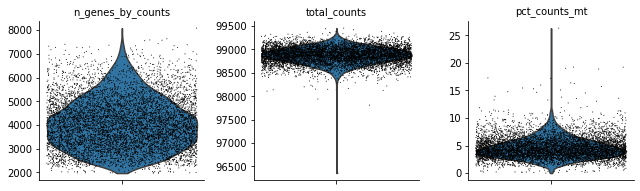

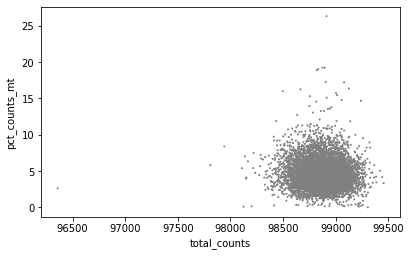

AnnData object with n_obs × n_vars = 7102 × 22722
    obs: 'CellLine', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'


In [8]:
# loading h5ad file
tp = 'Head and Neck Cancer'
file = tp.replace(' ','_')
adata_orig = sc.read_h5ad(folder+file+'.h5ad')
print(adata_orig)
adata_orig.var['mt'] = adata_orig.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata_orig, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(adata_orig, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)
sc.pl.scatter(adata_orig, x='total_counts', y='pct_counts_mt')
print(adata_orig)


In [9]:
# pre-processing

adata = adata_orig.copy()

top_variable_genes = 10000 # if negative then no selection of genes
Normalize_Totals = False
Already_Log_Transformed = False
n_neighbours_for_pooling = 10
number_of_pcs = 30

print('PREPROCESSING PARAMETERS:')
print('Already_Log_Transformed=',Already_Log_Transformed)
print('Normalize_Totals=',Normalize_Totals)
print('number_of_pcs=',number_of_pcs)
print('n_neighbours_for_pooling=',n_neighbours_for_pooling)
print('top_variable_genes=',top_variable_genes)

if n_neighbours_for_pooling>0:
    adata = pooling_procedure(adata,adata_orig)
adata = preprocessing_dataset(adata)

adata.write(folder+file+'_processed.h5ad',compression='gzip')

PREPROCESSING PARAMETERS:
Already_Log_Transformed= False
Normalize_Totals= False
number_of_pcs= 30
n_neighbours_for_pooling= 10
top_variable_genes= 10000


AnnData object with n_obs × n_vars = 7102 × 10000
    obs: 'CellLine', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [10]:
# make weighted gmt file from _S file
#sfile = 'ht29_ic15_S.xls'
sfile = folder+'JHU011_UPPER_AERODIGESTIVE_TRACT_ica_S.xls'
prefix = 'hn_'
threshold = 2
dfs = pd.read_csv(sfile,delimiter='\t')
dfs1 = dfs[dfs.columns[1:-1]]
gmtfile = sfile[:-4]+'_weighted.gmt'
with open(gmtfile,'w') as fout:
    for s in dfs1.columns:
        fout.write(prefix+s+'\tna\t')
        for i in range(dfs[s].shape[0]):
            val = float(dfs[s].iloc[i])
            gn = dfs[dfs.columns[0]].iloc[i]
            if abs(val)>threshold:
                fout.write(gn+'['+str(val)+']'+'\t')
        fout.write('\n')

In [11]:
signature_dict = load_weighted_signature_file(gmtfile)
sc.pp.highly_variable_genes(adata,n_top_genes=2001,n_bins=20)
ind_genes2k = np.where(adata.var['highly_variable'])[0]
adata2k = adata[:,ind_genes2k]
scores_dic = calc_weighted_scores(adata2k,signature_dict)
scores_dic['HISTONES'] = calc_histone_score(adata2k)

for s in scores_dic:
    adata.obs[s] = scores_dic[s]

Found histone genes: HIST1H2BK H1FX HIST1H4C H2AFX HIST3H2A HIST1H2AC HIST1H2BD HIST1H1D HIST1H1C HIST2H2AC HIST1H1E HIST1H1A HIST1H1B HIST1H2BJ HIST1H2BC HIST1H2BH HIST1H2BG HIST1H2AE HIST2H2BE HIST1H2BN HIST1H3G HIST1H4H


Trying to set attribute `.uns` of view, copying.


AnnData object with n_obs × n_vars = 7102 × 10000
    obs: 'CellLine', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'hn_IC1', 'hn_IC2', 'hn_IC3', 'hn_IC4', 'hn_IC5', 'hn_IC6', 'hn_IC7', 'hn_IC8', 'hn_IC9', 'hn_IC10', 'hn_IC11', 'hn_IC12', 'hn_IC13', 'hn_IC14', 'hn_IC15', 'HISTONES'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'


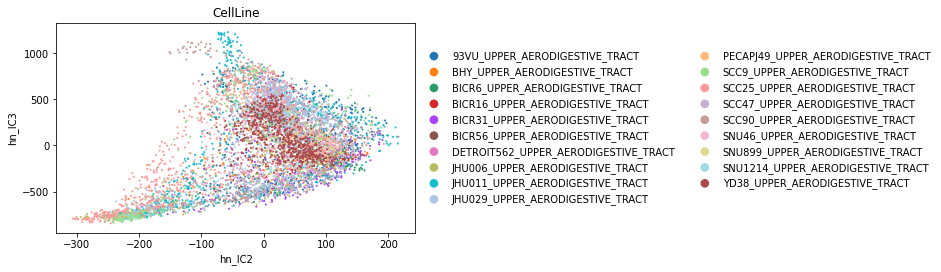

SCC47_UPPER_AERODIGESTIVE_TRACT : 592
93VU_UPPER_AERODIGESTIVE_TRACT : 572
JHU006_UPPER_AERODIGESTIVE_TRACT : 325
SCC25_UPPER_AERODIGESTIVE_TRACT : 898
JHU029_UPPER_AERODIGESTIVE_TRACT : 797
SNU46_UPPER_AERODIGESTIVE_TRACT : 236
PECAPJ49_UPPER_AERODIGESTIVE_TRACT : 202
BICR31_UPPER_AERODIGESTIVE_TRACT : 248
YD38_UPPER_AERODIGESTIVE_TRACT : 624
JHU011_UPPER_AERODIGESTIVE_TRACT : 717
BICR6_UPPER_AERODIGESTIVE_TRACT : 286
BICR16_UPPER_AERODIGESTIVE_TRACT : 212
SCC9_UPPER_AERODIGESTIVE_TRACT : 475
SCC90_UPPER_AERODIGESTIVE_TRACT : 258


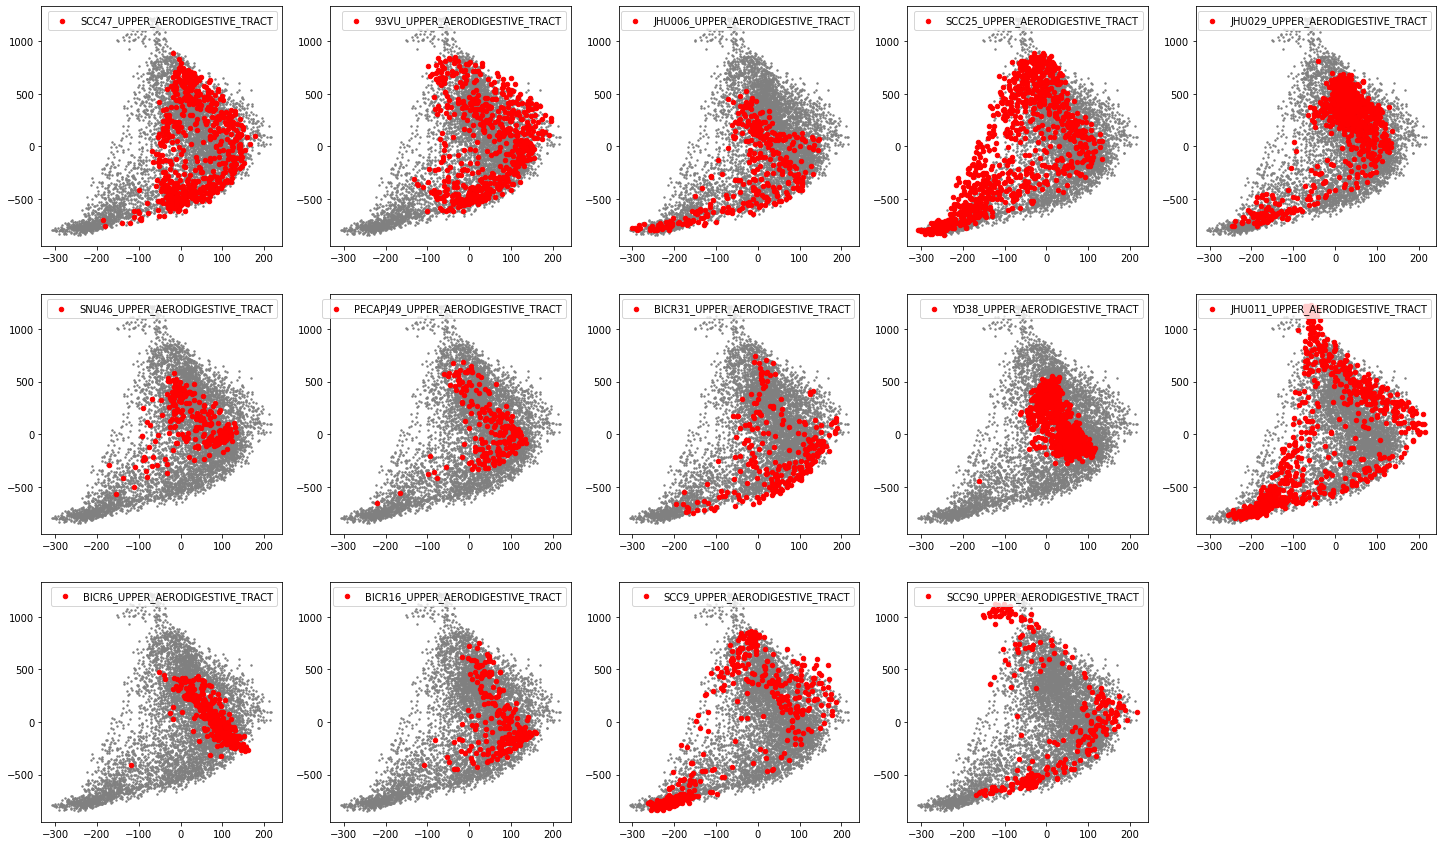

In [18]:
sx = 'hn_IC2'
sy = 'hn_IC3'

ind = np.where(np.array(cancer_types)==tp)[0]

print(adata)

sc.pl.scatter(adata[:,:],x=sx,y=sy,color='CellLine')

hn_celllines = list(np.array(cell_lines)[ind])
hn_celllines_unique = list(set(hn_celllines))
plt.figure(figsize=(25,15))
k = 0
for v in hn_celllines_unique:
    if hn_celllines.count(v)>200:
        print(v,':',hn_celllines.count(v))
        ind1 = np.where(np.array(hn_celllines)==v)[0]
        #sc.pl.scatter(adata[ind1,:],x=sx,y=sy)
        x = adata[ind1,:].obs[sx]
        y = adata[ind1,:].obs[sy]
        xt = adata[:,:].obs[sx]
        yt = adata[:,:].obs[sy]        
        #plt.scatter(x,y,s=5,label=v)
        #if v.startswith('SCC47'):
        plt.subplot(3,5,k+1)
        k = k+1
        plt.scatter(xt,yt,s=2,c='grey')
        plt.scatter(x,y,s=20,label=v,c='r')
        plt.legend()
plt.show()